In [233]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import pdb
from shapely.geometry import LineString, Point
from shapely import affinity
from shapely.ops import linemerge
from sklearn.neighbors import KDTree
import random
import reeds_shepp
from collections import deque

In [355]:
step_size = 0.1

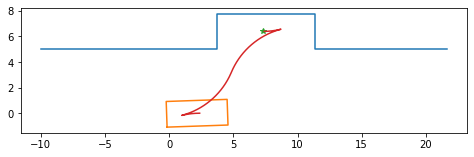

In [356]:
spotleng = 8.125
accumDist = 3.5
toTheRight = 5
errors = 0.25
spotwidth = 2.75
carwidth = 2
carleng = 4.75
planleng = spotleng - 2*errors
obstacles = [LineString([[-10,toTheRight],[errors+accumDist,toTheRight]]),
            LineString([[errors+accumDist,toTheRight],[errors+accumDist,toTheRight+spotwidth]]),
            LineString([[errors+accumDist,toTheRight+spotwidth],[errors+accumDist+planleng,toTheRight+spotwidth]]),
            LineString([[errors+accumDist+planleng,toTheRight+spotwidth],[errors+accumDist+planleng,toTheRight]]),
            LineString([[errors+accumDist+planleng,toTheRight],[10+accumDist+spotleng,toTheRight]])]

obstacles = linemerge(obstacles)

    
car = [LineString([[0,-carwidth/2],[0,carwidth/2]]),
       LineString([[0,-carwidth/2],[carleng,-carwidth/2]]),
       LineString([[0,carwidth/2],[carleng,carwidth/2]]),
       LineString([[carleng,carwidth/2],[carleng,-carwidth/2]])]

car = linemerge(car)
cargoal = affinity.translate(car,6,6)

goal = [accumDist + planleng/2, toTheRight + spotwidth/2]

path = reeds_shepp.path_sample((carleng/2,0,0), (goal[0],goal[1],0) , rho, step_size)
xs = [q[0] for q in path]
ys = [q[1] for q in path]
thetas = [q[2] for q in path]

node = 2
carturn = affinity.rotate(car,path[node][2]*180/np.pi, origin='centroid')
carmove = affinity.translate(carturn,path[node][0]-carleng/2,path[node][1])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.plot(obstacles.xy[0],obstacles.xy[1])
plt.plot(carmove.xy[0],carmove.xy[1])
# plt.plot(carturn.xy[0],carturn.xy[1])
# plt.plot(car.xy[0],car.xy[1])
plt.plot(goal[0],goal[1],'*')
plt.plot(xs, ys, '-')
ax.set_aspect('equal')
plt.show()

In [389]:
k = 0.5  # control gain
Kp = 1.0  # speed proportional gain
dt = 0.1  # [s] time difference
L = carleng/5  # [m] Wheel base of vehicle
max_steer = np.radians(30.0)  # [rad] max steering angle

show_animation = True


class State(object):
    """
    Class representing the state of a vehicle.
    :param x: (float) x-coordinate
    :param y: (float) y-coordinate
    :param yaw: (float) yaw angle
    :param v: (float) speed
    """

    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        """Instantiate the object."""
        super(State, self).__init__()
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v

    def update(self, acceleration, delta):
        """
        Update the state of the vehicle.
        Stanley Control uses bicycle model.
        :param acceleration: (float) Acceleration
        :param delta: (float) Steering
        """
        delta = np.clip(delta, -max_steer, max_steer)

        self.x += self.v * np.cos(self.yaw) * dt
        self.y += self.v * np.sin(self.yaw) * dt
        self.yaw += self.v / L * np.tan(delta) * dt
        self.yaw = normalize_angle(self.yaw)
        self.v += acceleration * dt


def pid_control(target, current):
    """
    Proportional control for the speed.
    :param target: (float)
    :param current: (float)
    :return: (float)
    """
    return Kp * (target - current)

def stanley_control(state, cx, cy, cyaw, last_target_idx):
    """
    Stanley steering control.
    :param state: (State object)
    :param cx: ([float])
    :param cy: ([float])
    :param cyaw: ([float])
    :param last_target_idx: (int)
    :return: (float, int)
    """
    current_target_idx, error_front_axle = calc_target_index(state, cx, cy)

    if last_target_idx >= current_target_idx:
        current_target_idx = last_target_idx

    # theta_e corrects the heading error
    theta_e = normalize_angle(cyaw[current_target_idx] - state.yaw)
    # theta_d corrects the cross track error
    theta_d = np.arctan2(k * error_front_axle, state.v)
    # Steering control
    delta = theta_e + theta_d

    return delta, current_target_idx


def normalize_angle(angle):
    """
    Normalize an angle to [-pi, pi].
    :param angle: (float)
    :return: (float) Angle in radian in [-pi, pi]
    """
    while angle > np.pi:
        angle -= 2.0 * np.pi

    while angle < -np.pi:
        angle += 2.0 * np.pi

    return angle


def calc_target_index(state, cx, cy):
    """
    Compute index in the trajectory list of the target.
    :param state: (State object)
    :param cx: [float]
    :param cy: [float]
    :return: (int, float)
    """
    # Calc front axle position
#     pdb.set_trace()
    fx = state.x + L * np.cos(state.yaw)
    fy = state.y + L * np.sin(state.yaw)

    # Search nearest point index
    dx = [fx - icx for icx in cx]
    dy = [fy - icy for icy in cy]
    d = np.hypot(dx, dy)
    target_idx = np.argmin(d)

    # Project RMS error onto front axle vector
    front_axle_vec = [-np.cos(state.yaw + np.pi / 2),
                      -np.sin(state.yaw + np.pi / 2)]
    error_front_axle = np.dot([dx[target_idx], dy[target_idx]], front_axle_vec)

    return target_idx, error_front_axle

In [394]:
target_speed = 0.25 / 3.6  # [m/s]

max_simulation_time = 200.0

state = State(x=0, y=0.0, yaw=0, v=0.0)

last_idx = len(xs) - 1
time = 0.0
x = [state.x]
y = [state.y]
yaw = [state.yaw]
v = [state.v]
t = [0.0]
target_idx, _ = calc_target_index(state, xs, ys)
dt = 0.1

sign = []
for i in range(len(xs)-1):
    if xs[i+1] > xs[i]:
        sign.append(1)
    else:
        sign.append(-1)
sign.append(-1)

In [395]:
while max_simulation_time >= time and last_idx > target_idx:
#     if time > 163.5:
#         pdb.set_trace()
    ai = pid_control(sign[target_idx]*target_speed, state.v)
    di, target_idx = stanley_control(state, xs, ys, thetas, target_idx)
    state.update(ai, di)

    time += dt

    x.append(state.x)
    y.append(state.y)
    yaw.append(state.yaw)
    v.append(state.v)
    t.append(time)
    
    if np.hypot(goal[0]-state.x,goal[1]-state.y) < 0.5:
        break
    

In [396]:
len(x)

1430

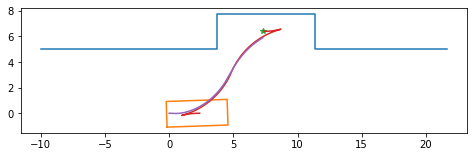

In [397]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.plot(obstacles.xy[0],obstacles.xy[1])
plt.plot(carmove.xy[0],carmove.xy[1])
# plt.plot(carturn.xy[0],carturn.xy[1])
# plt.plot(car.xy[0],car.xy[1])
plt.plot(goal[0],goal[1],'*')
plt.plot(xs, ys, '-')
plt.plot(x,y)
ax.set_aspect('equal')
plt.show()

In [27]:
#a better class for prm/rrt nodes
class treeNode:
    def __init__(self, n, loc, angle, vel, parent):
        self.neighbors = []
        self.name = n #the random integer name
        self.xyloc = loc #the actual location
        self.angle = angle
        self.vel = vel
        self.parent = parent #the parent's name
        
#a better class for prm/rrt nodes
class mytree:
    def __init__(self,nodes = {},edges = {}):
        self.V = {} #nodes
        self.E = {} #edges
        
    def addNode(self, n, loc, angle, vel, controls, parent = None):
        newNode = treeNode(n, loc, angle, vel, parent)
        if parent is not None:
            self.E[(parent,newNode)] = controls
        self.V[n] = newNode

In [28]:
def getNearest(tree,randLoc):
    minDist = np.inf
    minNode = None
    for v in tree.V.values():
        dist = np.sqrt((v.xyloc[0]-randLoc[0])**2+(v.xyloc[1]-randLoc[1])**2+(v.angle*180/np.pi-randLoc[2])**2)
        
        if dist < minDist:
            minDist = dist
            minNode = v
    
    return(v)

def calcdist(q,p):
    return(np.sqrt((q[0]-p[0])**2+(q[1]-p[1])**2+(q[2]-p[2])**2))

def getLocTraject(nearest, goal, velRange, steerRange, delT, car, obstacles, m = 100):
    bestU = None
    minDist = np.inf
    bestTrajec = None
    theta0 = nearest.angle
    vel0 = nearest.vel
    [x0,y0] = nearest.xyloc
    leng = (car.xy[0][2]-car.xy[0][1])/2
    
    for i in range(m):
        uVel = random.uniform(velRange[0],velRange[1])
        uSteer = random.uniform(steerRange[0],steerRange[1])
                 
        xLast = x0
        yLast = y0
        theta = theta0
        xVec = [xLast]
        yVec = [yLast]
        thetaVec = [theta]
        lastdist = np.inf
        newdist = calcdist(goal,[xLast,yLast,theta])
        randTime = 0
        distTravel = 0
        badPath = False
        while newdist < lastdist and distTravel < 4 and not badPath: 
            # Update next value of x, y, and theta
            x = xLast + delT * uVel * np.cos(theta)
            y = yLast + delT * uVel * np.sin(theta)
            theta = theta + delT * uVel/leng * np.tan(uSteer * np.pi/180)
            
            badPath = obstacles.intersects(affinity.rotate(affinity.translate(car,x,y),theta*180/np.pi))
            
            randTime += delT 
            
            distTravel += np.hypot(x-xLast,y-yLast)
            
            xLast = x
            yLast = y
            
            xVec.append(x)
            yVec.append(y)
            thetaVec.append(theta)
            
            lastdist = newdist
            newdist = calcdist(goal,[x,y,theta])
            
        if badPath:
            continue

        dist = calcdist(goal,[x,y,theta])
        if dist < minDist:
            bestU = [uVel,uSteer,randTime]
            minDist = dist
            bestTrajec = [xVec,yVec,thetaVec]
            
    return(bestU, bestTrajec)

def getPath(newNode,tree):
    path = [newNode]
    
    current = newNode.parent
    while current.parent is not None:
        path.append(current)
        current = current.parent
    path.append(current)
    
    path = np.flipud(path)
    
    controls = []
    for p in range(len(path)-1):
        controls.append(tree.E[(path[p],path[p+1])])
        
    controls.append(tree.E[(path[-2],path[-1])])
        
    return(np.flipud(path),controls)

In [29]:
def rrtStar(start, goal, xBounds, yBounds, obstacles, car, n, pgoal = 0.15, epsilon = 1, velRange = [-5,5], steerRange = [-30,30], delT = 10*1e-1):
    G = mytree() #define a graph
    
    #initialization with the starting node
    G.addNode('Start',start[0:2],start[2],0,None)
    listOfLoc = [start]
    listOfInd = ['Start']
    minDist = np.inf
    
    for i in range(n):
        pop = KDTree(np.array(listOfLoc))
        prob = random.random()
        if prob > pgoal:
            randX = random.uniform(xBounds[0],xBounds[1])
            randY = random.uniform(yBounds[0],yBounds[1])
            randTheta = random.uniform(steerRange[0],steerRange[1])
        else:
            randX = goal[0]
            randY = goal[1]
            randTheta = 0
                        
#         nearestNode = getNearest(G,[randX,randY,randTheta])
#         pdb.set_trace()
        dist, ind = pop.query(np.array([[randX,randY,randTheta]]), k=1)   
        nearestNode = G.V[listOfInd[ind[0][0]]]

        [controls,trajec] = getLocTraject(nearestNode, [randX,randY,randTheta], velRange, steerRange, delT, car, obstacles)
#         pdb.set_trace()
        if xBounds[0] < trajec[0][-1] < xBounds[1] and yBounds[0] < trajec[1][-1] < yBounds[1]:
            contact = False
#             for j in range(len(trajec[0])):
#                 carRot = affinity.rotate(car,trajec[2][j]*180/np.pi)
#                 carTrans = affinity.translate(carRot,trajec[0][j],trajec[1][j])
#                 if obstacles.intersects(carTrans):
#                     contact = True
#                     continue
            if contact:
                continue
            else:
                G.addNode(i,[trajec[0][-1],trajec[1][-1]],trajec[2][-1],0,controls,parent = nearestNode)
                listOfLoc.append([trajec[0][-1],trajec[1][-1],trajec[2][-1]])
                listOfInd.append(i)
                pop = KDTree(np.array(listOfLoc))
                
                dist = calcdist([goal[0],goal[1],0],[trajec[0][-1],trajec[1][-1],trajec[2][-1]])

                if dist < epsilon:
#                     pdb.set_trace()
                    [path,controls] = getPath(G.V[i],G)

                    return(path,controls,G)
                elif dist < minDist:
                    minDist = dist
                    bestNode = G.V[i]
      
    print('Bad Path')
    [path,controls] = getPath(bestNode,G)
    return(path,controls,G)

In [30]:
n = 200
start = [-5,0,0]
# goal = [6,6] #x and y location

[path,control,G] = rrtStar(start, goal, [-10,accumDist+spotleng+5],[0,toTheRight + spotwidth], obstacles, car, n)

Bad Path


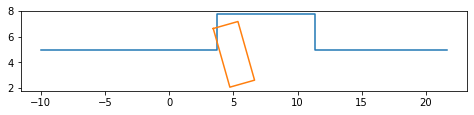

In [37]:
node = 0
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.plot(obstacles.xy[0],obstacles.xy[1])
carxy = affinity.translate(affinity.rotate(car,-path[node].angle*180/np.pi),path[node].xyloc[0],path[node].xyloc[1])
plt.plot(carxy.xy[0],carxy.xy[1])
ax.set_aspect('equal')
plt.show()

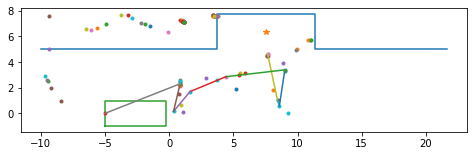

In [36]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.plot(obstacles.xy[0],obstacles.xy[1])
plt.plot(goal[0],goal[1],'*')
plt.plot(car.xy[0],car.xy[1])
for p in G.V.values():
    plt.plot(p.xyloc[0],p.xyloc[1],'.')
    
for p in range(len(path)-1):
    plt.plot([path[p].xyloc[0],path[p+1].xyloc[0]],[path[p].xyloc[1],path[p+1].xyloc[1]])
#plt.plot([path[-1].xyloc[0],path[-2].xyloc[0]],[path[-1].xyloc[1],path[-2].xyloc[1]])
ax.set_aspect('equal')
plt.show()

In [194]:
global a, dt, carleng
dt = 1
a = carleng**2

In [ ]:
def dist(p,q):
    dtheta = p[2] - q[2]
    if dtheta > np.pi:
        dtheta += -2*np.pi
    elif dtheta < -np.pi:
        dtheta += 2*np.pi
        
    d = np.sqrt((p[0]-q[0])**2+(p[1]-q[1])**2+a*(dtheta)**2)
    
    return(d)

def nearVert(q, tree):
    d = np.inf
    near = None
    
    for v in tree.V.values():
        dr = dist([v.xyloc,v.angle],q)
        if (dr < d):
            near = v
            d = dr
    return(near)

def randConf(xBound,yBound,angleBound):
    qx = random.uniform(xBound[0],xBound[1])
    qy = random.uniform(yBound[0],yBound[1])
    qtheta = random.uniform(angleBound[0],angleBound[1])
    
    return([qx,qy,qtheta])

def goalRegionBias(goal, PG, d, xBound, yBound, angleBound):
    x = random.random()
    
    if x < PG:
        return(goal)
    elif x < 0.5:
        q = randConf(xBound, yBound, angleBound)
        while dist(q,goal) > 2*d:
            q = randConf(xBound, yBound, angleBound)
        return(q)
    else:
        q = randConf(xBound, yBound, angleBound)
        return(q)
    
def newConf(near, controls):
    [xNear,yNear] = near.xyloc
    angNear = near.angle
    
    newx = xNear + controls[0]*dt*np.cos(angNear)*np.cos(controls[1])
    newy = yNear + controls[0]*dt*np.sin(angNear)*np.cos(controls[1])
    newang = angNear + (controls[0]/carleng)*np.sin(controls[1])
    
    return(newx,newy,newang)

def optInp(near, q, obstacles):
    